# Tracking COVID19 Using XY.ai Analytic Tools and Resources

## Introduction

Coronavirus 19, or COVID-19 / or severe acute respiratory disease 2 (SARS-CoV2, https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it) is a respiratory disease that was discovered in Wuhan, China in December, 2019. The virus is thought to spread through droplet transmission, and can result in severe pneumonia and death. While information about the virus is rapidly changing, there are over 100,000 people infected worldwide, and there have been predictions about how quickly the virus will spread (https://www.who.int/news-room/detail/07-03-2020-who-statement-on-cases-of-covid-19-surpassing-100-000).

An important part of determining which populations will be affected and which groups of individuals/communities to prioritize for preventive efforts (encourage handwashing, self-quarantine when appropriate, avoiding public gatherings, etc) is discovering what the comorbidities of a COVID-19 infection are. Currently, it appears as though one of the main risk factors for infection is being older (> 60 years).

In this XY.ai blog post, we will examine the basic epidemiology of COVID-19 in the United States, and then develop a "risk score" based on presumed co-morbidities for COVID-19 infection. Generally, the following can be thought of as risk factors for a viral infection:

<br> Immunosuppression - due to medications and chronic conditions
<br> Respiratory conditions - such as COPD and asthma in older individuals
<br> Smoking - which may compromise lung function and predispose to a respiratory infection
<br> Access to healthcare
<br> Demographics - such as age

Since the epidemiology of COVID-19 is evolving, the risk index will have to evolve with the data.


## Part 1: Plotting Data by State

To start, let's plot the CDC's current COVID-19 data, which is available here (https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html). This will give us an idea of which states are hotspots.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import folium
import pandas as pd
import shapely.wkt
from shapely.geometry import mapping, shape
import geojson
from sqlalchemy import func
from collections import defaultdict
#from IPython.display import IFrame
from IPython.display import display_html
    
############################
### Getting COVID19 Data ###
############################

# We will load the COVID 19 data from a TSV (Tab-separated values) file
# Format: Name (\t) ID (\t) Range (\t) Cases (\t) Reported
covid19data = defaultdict(int)
tfile = "covid19-cdc-10032020.tsv"
with open(tfile, "r") as infile:
    line = infile.readline()
    for line in infile:
        line = line.strip()
        ldata = line.split("\t")
        if len(ldata) > 1:
            tstate = ldata[1].upper().strip()
            trate = ldata[2]
            if ldata[2] == "None":
                trate = 0
            if ldata[2].find('-') > -1:
                rdata = ldata[2].split('-')
                trate = int(rdata[1])
            covid19data[tstate] = trate
            #print("State:" + ldata[0] + "\t" + "Cases Reported: " + ldata[2])
infile.close()


In [2]:
# Now let's take the COVID19 data and plot it on a map:

tJSON = "us-states.json"

# Now make a Pandas dataframe from our previous dictionary:
covid19df = pd.DataFrame(list(covid19data.items()), columns=['id', 'rate'])
#print dataframe to see if data looks okay...
#print(covid19df)

# Initialize the map:
covid19map = folium.Map(location=[35, -100], zoom_start=4.3)
 
# Add the color for the chloropleth:
folium.Choropleth(geo_data=tJSON, name='choropleth', data=covid19df, columns=['id', 'rate'], key_on='feature.id', fill_color='YlOrRd',
 fill_opacity=0.7, line_opacity=0.2, legend_name='COVID19 Cases').add_to(covid19map)

# ... and display the map
covid19map

## Part 2: Finding Regions at Risk Using 500 Cities Data

Now, using the CDC's 500 cities data, we can look into the relationship between several potential risk factors for COVID-19 infection, such as cancer, asthma, COPD, CHD, stroke, smoking, diabetes, and access to healthcare prevalence. For age, we'll use the median age calculated in the US census for each zipcode / census tract. We will bin the age data into child (< 18 years median age), young adult (18-35 years), adult (35-60 years), and seniors (>= 60 years).


Select "CANCER_CrudePrev", "STROKE_CrudePrev", "ACCESS2_CrudePrev", "CASTHMA_CrudePrev", "COPD_CrudePrev", "CHD_CrudePrev", "OBESITY_CrudePrev", "CSMOKING_CrudePrev", "DIABETES_CrudePrev", stateabbr, placename, "Geolocation", fips_place_tract, fips_tract from edw.fivehundredcities_data
            Cancer    Stroke       CHD    Access      COPD  Diabetes   Smoking
Cancer    1.000000  0.188570  0.501249 -0.385292  0.135577  0.116493 -0.641262
Stroke    0.188570  1.000000  0.911060  0.690909  0.921909  0.955614  0.429033
CHD       0.501249  0.911060  1.000000  0.481111  0.878808  0.869477  0.181906
Access   -0.385292  0.690909  0.481111  1.000000  0.728327  0.692306  0.811478
COPD      0.135577  0.921909  0.878808  0.728327  1.000000  0.916814  0.578168
Diabetes  0.116493  0.955614  0.869477  0.692306  0.916814  1.000000  0.478998
Smoking  -0.641262  0.429033  0.181906  0.811478  0.578168  0.478998  1.000000


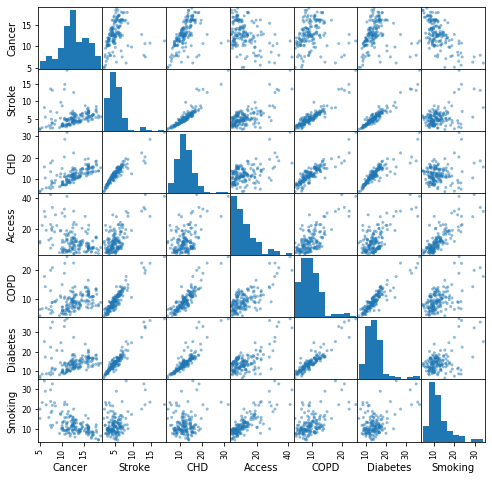

In [46]:
def GetDBConnection(tmode):
    
    if tmode == "cdc500":
        # Note: when we publish this blog post, the below data will be changed to localhost/template1/postgres
        hostDB = "xy-ai-server-02-06-2020.ccp7icrordwn.us-east-1.rds.amazonaws.com"
        tDB = "chiraglab"
        tUser = "root"
        tPassword = "wUF9WvjYLbgy3kFJ"
        
    if tmode == 'census':
        #EDB
        hostDB = '104.196.156.226'
        tDB = 'postgres'
        tUser = 'postgres'
        tPassword = 'edb'
    
    #hostDB = "localhost"
    #tDB = "template1"
    #tUser = "postgres"
    #tPassword = ""
    conn = psycopg2.connect(host=hostDB, database=tDB, user=tUser, password=tPassword)
    cur = conn.cursor(cursor_factory=RealDictCursor)    
    return conn, cur


######################################
### Getting 500 Cities Data - 2013 ###
######################################

# Connect to database and store in dictionary
conn, cur = GetDBConnection('cdc500')

# Let's get the 500 Cities data stored in the database using an SQL query
diseaselist = ["CANCER_CrudePrev", "STROKE_CrudePrev", "ACCESS2_CrudePrev", "CASTHMA_CrudePrev", "COPD_CrudePrev", "CHD_CrudePrev", "OBESITY_CrudePrev", "CSMOKING_CrudePrev", "DIABETES_CrudePrev"]
tcollist = '"{0}"'.format('", "'.join(diseaselist))
tsql = 'Select ' + tcollist + ', stateabbr, placename, "Geolocation", fips_place_tract, fips_tract from edw.fivehundredcities_data'
print(tsql)
cur.execute(tsql)
cdc500 = cur.fetchall()

# We've finished querying the database, now close the connections
cur.close()
conn.close()

#################################
### Getting Census Data - Age ###
#################################
conn2, cur2 = GetDBConnection('census')
cur2.execute('select b.statefip, b.fipcode, b.geoid, a.shape_id, a.median_household_income, a.median_age from edb_docai.ses_census_tract a inner join edw.shapefile b on (a.shape_id::INTEGER=b.shape_id)')
agedata = cur2.fetchall()
cur2.close()
conn2.close()

# now match fips tract and geoid: left_on='fips_tract', right_on='geoid'
finaltable = defaultdict(lambda: defaultdict(str))
for trow in cdc500:
    ldata = trow['fips_place_tract'].split('-')
    tstate = trow['fips_place_tract'][:2]
    if len(ldata) > 1:
        fipsid = ldata[1]
        # Fix the FIPS ID based on state code:
        if (str(tstate)[0] == "0"):
            fipsid = ldata[1].zfill(11)
        finaltable[fipsid]['stateabbr'] = trow['stateabbr']
        finaltable[fipsid]['placename'] = trow['placename']
        for x in diseaselist:
            finaltable[fipsid][x] = trow[x]

# now merge with median age data from census, classify as youth, adult, etc.
tmatch = 0
for trow in agedata:
    ttract = trow['geoid']
    if ttract in finaltable:
        if trow['median_age'] is not None:
            tage = int(trow['median_age'])
            tclass = "none"
            if tage < 18:
                tclass = "youth"
            if (tage >= 18) & (tage <= 35):
                tclass = "young adult"
            if (tage > 35) & (tage < 60):
                tclass = "adult"
            if (tage >= 60):
                tclass = "senior"
            finaltable[ttract]['median_age'] = trow['median_age']
            finaltable[ttract]['median_household_income'] = trow['median_household_income']
            finaltable[ttract]['ageclass'] = tclass
            tmatch += 1

#print("Number of matches: " + str(tmatch))

# Now plot low income, asthma, smoking, COPD, access to health care intercorrelations for Washington, California, New York
# for different age bins
# diseaselist = ["ACCESS2_CrudePrev", "CASTHMA_CrudePrev", "COPD_CrudePrev", "CHD_CrudePrev", "OBESITY_CrudePrev", "CSMOKING_CrudePrev", "DIABETES_CrudePrev"]
cancervals = np.array([])
strokevals = np.array([])
accessvals = np.array([])
asthmavals = np.array([])
copdvals = np.array([])
chdvals = np.array([])
obesityvals = np.array([])
diabetesvals = np.array([])
smokingvals = np.array([])
arthritisvals = np.array([])
for tfips in finaltable:
    if (finaltable[tfips]['ageclass'] == "senior"):
        cancervals = np.append(cancervals, finaltable[tfips]['CANCER_CrudePrev'])
        strokevals = np.append(strokevals, finaltable[tfips]['STROKE_CrudePrev'])
        accessvals = np.append(accessvals, finaltable[tfips]['ACCESS2_CrudePrev'])
        asthmavals = np.append(asthmavals, finaltable[tfips]['CASTHMA_CrudePrev'])
        copdvals = np.append(copdvals, finaltable[tfips]['COPD_CrudePrev'])
        chdvals = np.append(chdvals, finaltable[tfips]['CHD_CrudePrev'])
        obesityvals = np.append(obesityvals, finaltable[tfips]['OBESITY_CrudePrev'])
        diabetesvals = np.append(diabetesvals, finaltable[tfips]['DIABETES_CrudePrev'])
        smokingvals = np.append(smokingvals, finaltable[tfips]['CSMOKING_CrudePrev'])

# plot correlations
df = pd.DataFrame({'Cancer': cancervals, 'Stroke': strokevals, 'CHD': chdvals, 'Access': accessvals, 'COPD': copdvals, 'Diabetes': diabetesvals, 'Smoking': smokingvals})
print(df.corr())
pd.plotting.scatter_matrix(df, figsize=(8, 8))
plt.show()

# correlate each outcome with age as well - scatterplot


## Part 3: Ranking at Risk Regions based on Chronic Diseases

Now that we've examined the relationships between potential COVID-19 comorbidities, we can put together a simple risk index using a weighted average fo the prevalences of different conditions. We can also test different models by changing the weighting systematically, or using existing evidence-baesd weighting methods. Here's we'll select eight prevalences and take a simple average to start.

In [53]:
# coefficients - can be QALY, DALY, etc.

# specify coefficients based on the diseases / prevalences from diseaselist defined above:
diseasemodel = ["CANCER", "ACCESS2", "CASTHMA", "COPD", "CSMOKING", "CHD"]
model1 = [2, 3, 1, 1, 1, 2]
model2 = [2, 2, 2, 2, 1, 1]

covidindex = defaultdict(float)
for tfips in finaltable:
    if (finaltable[tfips]['ageclass'] == "senior"):
        for x in range(0, len(diseasemodel) - 1):
            covidindex[tfips] += model1[x] * float(finaltable[tfips][diseasemodel[x] + "_CrudePrev"])
        covidindex[tfips] = covidindex[tfips] / 10

# print out ranking by index:
trank = 1
statecnt = defaultdict(int)
print("Rank\tScore\tState\tPlace Name")
for w in sorted(covidindex, key=covidindex.get, reverse=True):
    if trank <= 20:
        print(str(trank) + "\t" + str(covidindex[w]) + "\t" + finaltable[w]['stateabbr'] + "\t" + finaltable[w]['placename'])
    statecnt[finaltable[w]['stateabbr']] += 1
    trank += 1

# print out state ranking
print("\nState\tNumber of High Risk Census Tracts")
for tstate in sorted(statecnt, key=statecnt.get, reverse=True):
    print(tstate + "\t" + str(statecnt[tstate]))





Rank	Score	State	Place Name
1	20.650000000000002	NY	New York
2	20.47	NY	New York
3	18.75	OH	Cleveland
4	17.6	NY	New York
5	17.29	FL	Tampa
6	17.160000000000004	OK	Oklahoma City
7	16.160000000000004	CA	Long Beach
8	15.77	NY	New York
9	15.180000000000001	CA	Pomona
10	14.75	FL	Pembroke Pines
11	14.5	FL	Largo
12	13.209999999999999	NY	New York
13	13.16	FL	Boynton Beach
14	13.099999999999998	FL	Sunrise
15	13.079999999999998	FL	Deerfield Beach
16	12.95	FL	Boynton Beach
17	12.74	CA	Hemet
18	12.59	FL	Pembroke Pines
19	12.559999999999999	FL	Largo
20	12.040000000000001	FL	Sunrise

State	Number of High Risk Areas
AZ	41
FL	40
CA	29
NY	14
NV	9
NM	4
PA	3
TX	3
IL	2
CO	2
MN	2
OH	1
OK	1
MI	1
WI	1
MA	1
SC	1
MD	1


## Conclusions

Having generated a very simple risk index, it is possible to extend this preliminary analysis and develop a more rigorous, scientific risk index based on more rigorous scientific evidence, and solid statistical framework, and incorporating geospatial information from the XY.ai platform, which we will do in the next blog post.

Rankings based on risk indices can help public health and primary care prioritize which areas are going to be disproportionately impacted by COVID-19, and implement preventive measures at the earliest possible time in these regions, which can include increased surveillence, increased resources, and focused educational campaigns.